In [2]:
import sys

sys.path.append(
    "/Users/mateo/Documents/Máster Big Data/TFM/codes/urbana-barcelona-master/src"
)

In [3]:
import os
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pysal.model import mgwr
from scipy.stats import pearsonr
from sklearn.preprocessing import PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split

from urbana.models.plot_predictions import PredictedAccuracy
from urbana.constants import DIR_REPO, DIR_DATA, RANDOM_STATE

# Data import 

In [5]:
#Parameters
YEAR = 2023  # ALLOWED_YEARS = [2017, 2018, 2023]
MONTH = 12

OUTPUT_WARNINGS = False
SAVE_FIGS = False
FIT_INTERCEPT = True

VARIABLE_TO_PREDICT = "Airbnb_Number"

#Warnings
if OUTPUT_WARNINGS is False:
    import warnings

    warnings.filterwarnings("ignore")

#Parameters check
ALLOWED_YEARS = [2017, 2018, 2023]
if YEAR not in ALLOWED_YEARS:
    raise Exception("Please select a year within: {}".format(ALLOWED_YEARS))

if YEAR == 2018 and MONTH == 3:
    raise Exception(
        "Month 3 (March) is not available for 2018. Please choose a different month."
    )

# Directories for linear model coefficients
DIR_VAR = DIR_DATA / "processed/{}".format(VARIABLE_TO_PREDICT)
DIR_MONTH = DIR_VAR / "{}_{:02d}".format(YEAR, MONTH)
DIR_EDA = DIR_MONTH / "00_eda"

PATH_TO_FILE = DIR_DATA / "interim/sections_{}_{:02d}.csv".format(YEAR, MONTH)
if os.path.isfile(PATH_TO_FILE) is False:
    raise Exception(
        'Please run first the notebook "00acquisition.ipynb" with the same date and "SAVE_DATA" set to True'
    )

PATH_TO_FILE = DIR_MONTH / "01_linear/coefficients.csv"
if os.path.isfile(PATH_TO_FILE) is False:
    raise Exception(
        'Please run first the notebook "01linear.ipynb" with the same date and "SAVE_MODEL" set to True'
    )

In [12]:
sect = pd.read_csv(DIR_DATA / "interim/sections_{}_{:02d}.csv".format(YEAR, MONTH))
sect.set_index("Tag", inplace=True)
sect.drop(["N_district", "N_neighbourhood", "N_section", "Airbnb_Price", "Airbnb_Price_Person", "Airbnb_Location_Score","Percentage_Age_25_39"], axis=1, inplace=True)

X = sect.drop(VARIABLE_TO_PREDICT, axis=1)
y = sect[VARIABLE_TO_PREDICT]

geo_info = gpd.read_file(DIR_DATA / "interim/sections_geo.json")
geo_info.set_index("Tag", inplace=True)
geo_info[VARIABLE_TO_PREDICT] = sect[VARIABLE_TO_PREDICT]

Area with maximum value: 02_077


In [15]:
pd.set_option('display.max_columns', None)

sect.head()

,Distance_Center,POI_Daily_Food,POI_Daily_Others,POI_House_Equipment,POI_Clothing,POI_Culture,POI_Vehicles,POI_State_Agents,POI_Education,POI_Finances,POI_Restaurants_Hotels,POI_Health,POI_Souvenirs_Thrift_Store,POI_Car_Parks,POI_Esthetics,POI_Sports,POI_Religion,POI_Administration,Airbnb_Number,Percentage_Gender_Female,Percentage_Age_0_14,Percentage_Age_15_24,Percentage_Age_40_64,Percentage_Age_65_Plus,Household,Education_None,Education_Primary_School,Education_Middle_School,Education_High_School,Education_University,Nationality_Spain,Nationality_Italy,Nationality_France,Nationality_UK,Nationality_Russia,Nationality_Germany,Nationality_Romania,Nationality_Portugal,Nationality_Ucrany,Nationality_Poland,Nationality_Netherlands,Nationality_Bulgaria,Nationality_Sweden,Nationality_Belgium,Nationality_Ireland,Nationality_Greece,Nationality_Switzerland,Nationality_Hungary,Nationality_Morocco,Nationality_Argelia,Nationality_Senegal,Nationality_Nigeria,Nationality_Colombia,Nationality_Honduras,Nationality_Venezuela,Nationality_Peru,Nationality_Argentina,Nationality_Bolivia,Nationality_Brazil,Nationality_Ecuador,Nationality_Dominican_Republic,Nationality_USA,Nationality_Mexico,Nationality_Chile,Nationality_Paraguay,Nationality_Cuba,Nationality_El_Salvador,Nationality_Uruguay,Nicaragua,Nationality_Pakistan,Nationality_China,Nationality_Philippines,Nationality_India,Nationality_Bangladesh,Nationality_Georgia,Nationality_Armenia,Nationality_Japan,Nationality_Nepal,Nationality_Turkey,Nationality_Iran,Nationality_Oceania,Rent_Number_Flats,Rent_Price_Meter_Flats,Rent_Price_Total_Flats,Rent_Area_Flats
Tag,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01_001,1.532922,6,1,0,0,2,0,0,4,0,33,2,8,1,1,1,1,4,76,0.464203,0.123172,0.087760,0.318707,0.143957,2.52,0.011474,0.211827,0.248897,0.202118,0.319506,0.535330,0.039171,0.016129,0.012289,0.009217,0.006144,0.005376,0.007680,0.004608,0.006912,0.004608,0.000000,0.001536,0.000768,0.000768,0.003072,0.001536,0.000000,0.019201,0.005376,0.002304,0.000768,0.003840,0.000768,0.003840,0.006912,0.015361,0.006912,0.006912,0.001536,0.006144,0.006144,0.006912,0.002304,0.003072,0.000768,0.001536,0.001536,0.000768,0.055300,0.009985,0.018433,0.070661,0.049923,0.006144,0.000000,0.000768,0.000768,0.000768,0.000000,0.000000,107.0,13.228132,769.0,57.0
01_002,1.060772,3,2,1,2,1,0,0,2,0,19,0,3,0,5,0,0,0,61,0.486604,0.101376,0.126720,0.281680,0.133961,2.60,0.023200,0.220800,0.251200,0.194400,0.301600,0.401429,0.047857,0.029286,0.023571,0.011429,0.011429,0.008571,0.006429,0.010000,0.005000,0.005000,0.000000,0.005714,0.000000,0.002143,0.002857,0.000714,0.000714,0.032143,0.007857,0.000714,0.000000,0.010000,0.002857,0.004286,0.009286,0.016429,0.005000,0.002857,0.004286,0.005000,0.004286,0.004286,0.005000,0.000000,0.001429,0.002857,0.001429,0.000000,0.065000,0.017857,0.035000,0.045000,0.081429,0.008571,0.005000,0.000000,0.000000,0.002143,0.000000,0.000714,65.0,13.080019,867.0,65.0
01_003,1.262231,9,3,1,2,3,0,0,5,2,20,3,1,2,3,1,0,1,50,0.458248,0.200466,0.130637,0.291824,0.108525,3.23,0.012806,0.296744,0.256129,0.192828,0.211123,0.541967,0.027978,0.010384,0.008365,0.002019,0.003173,0.009518,0.004327,0.001154,0.002019,0.002019,0.002019,0.003750,0.001442,0.000577,0.000000,0.000865,0.000288,0.042977,0.006922,0.002596,0.007499,0.011249,0.004327,0.006634,0.008653,0.008941,0.005769,0.002596,0.004038,0.001442,0.003750,0.004038,0.001442,0.001154,0.001731,0.002307,0.000288,0.000288,0.077300,0.018748,0.025094,0.061436,0.034035,0.000000,0.000288,0.000865,0.004038,0.000865,0.000000,0.000288,164.0,14.000000,700.0,50.0
01_004,1.180517,13,4,8,2,5,0,2,3,3,36,1,3,1,9,1,2,3,82,0.450767,0.122317,0.111414,0.329472,0.100170,2.65,0.010937,0.227734,0.246875,0.206250,0.292578,0.514771,0.045161,0.017997,0.009847,0.009168,0.003396,0.004414,0.005772,0.003396,0.004075,0.004075,0.001019,0.003056,0.002377,0.000679,0.002377,0.000340,0.001019,0.028862,0.007131,0.000000,0.000340,0.009508,0.001698,0.012564,0.007810,0.008829,0

In [17]:
geo_info.head()

,geometry,Airbnb_Number
Tag,,
01_001,"POLYGON ((2.17575 41.37827, 2.17552 41.37865, ...",76
01_002,"POLYGON ((2.17510 41.37905, 2.17470 41.37951, ...",61
01_003,"POLYGON ((2.17220 41.37692, 2.17206 41.37696, ...",50
01_004,"POLYGON ((2.16962 41.37847, 2.16962 41.37847, ...",82
01_005,"POLYGON ((2.17366 41.38071, 2.17330 41.38113, ...",108


# Target Variable

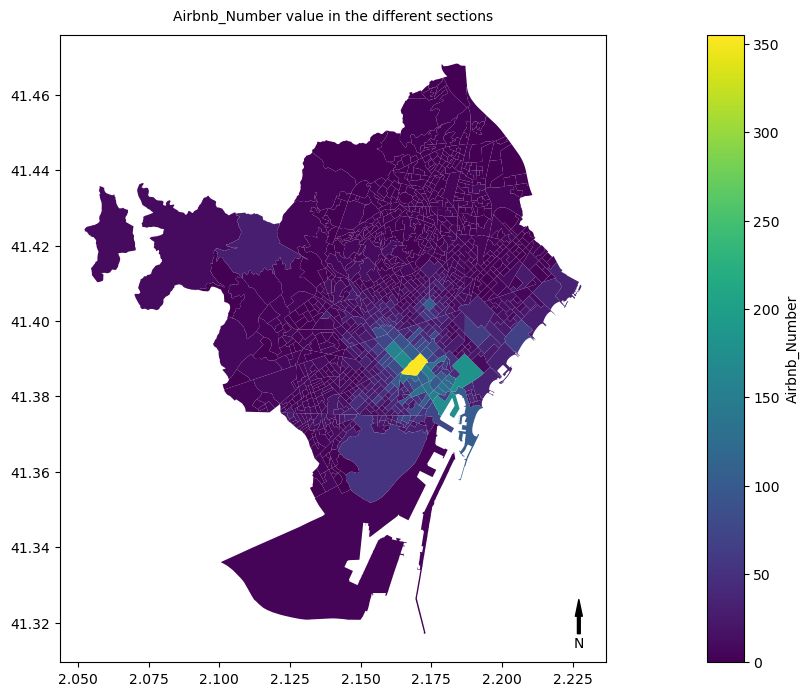

In [42]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(10, 10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
geo_info.plot(
    ax=ax,
    column=VARIABLE_TO_PREDICT,
    legend=True,
    cmap="viridis",
    legend_kwds={"shrink": 0.7, "label": str(VARIABLE_TO_PREDICT)},
    cax=cax,
)

x, y, arrow_length = 0.95, 0.1, 0.07
ax.annotate(
    "N",
    xy=(x, y),
    xytext=(x, y - arrow_length),
    arrowprops=dict(facecolor="black", width=2, headwidth=5),
    ha="center",
    va="center",
    fontsize=10,
    xycoords=ax.transAxes,
)

ax.set_title(
    str(VARIABLE_TO_PREDICT) + " value in the different sections", fontsize=10, y=1.01
)

if SAVE_FIGS is True:
    plt.savefig(DIR_EDA / "target_variable.svg", format="svg")

plt.show()

This plot shows the geographical distribution of the number of Airbnbs in Barcelona. It can be seen that there is a high concentration in the city center, and that it is apparently reduced when increasing the distance. In addition, the regions with a lower number of Airbnbs show a low variability.

[]

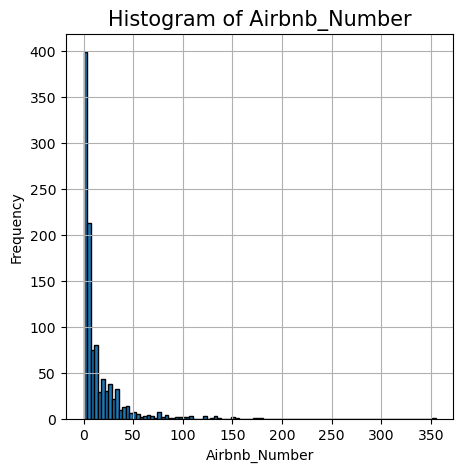

In [50]:
fig, ax = plt.subplots(figsize=(5, 5))

geo_info[VARIABLE_TO_PREDICT].hist(ax=ax, bins=100, edgecolor="black")
ax.set_title("Histogram of " + str(VARIABLE_TO_PREDICT), fontsize=15)
ax.set_xlabel(VARIABLE_TO_PREDICT, fontsize=10)
ax.set_ylabel("Frequency", fontsize=10)

ax.plot()

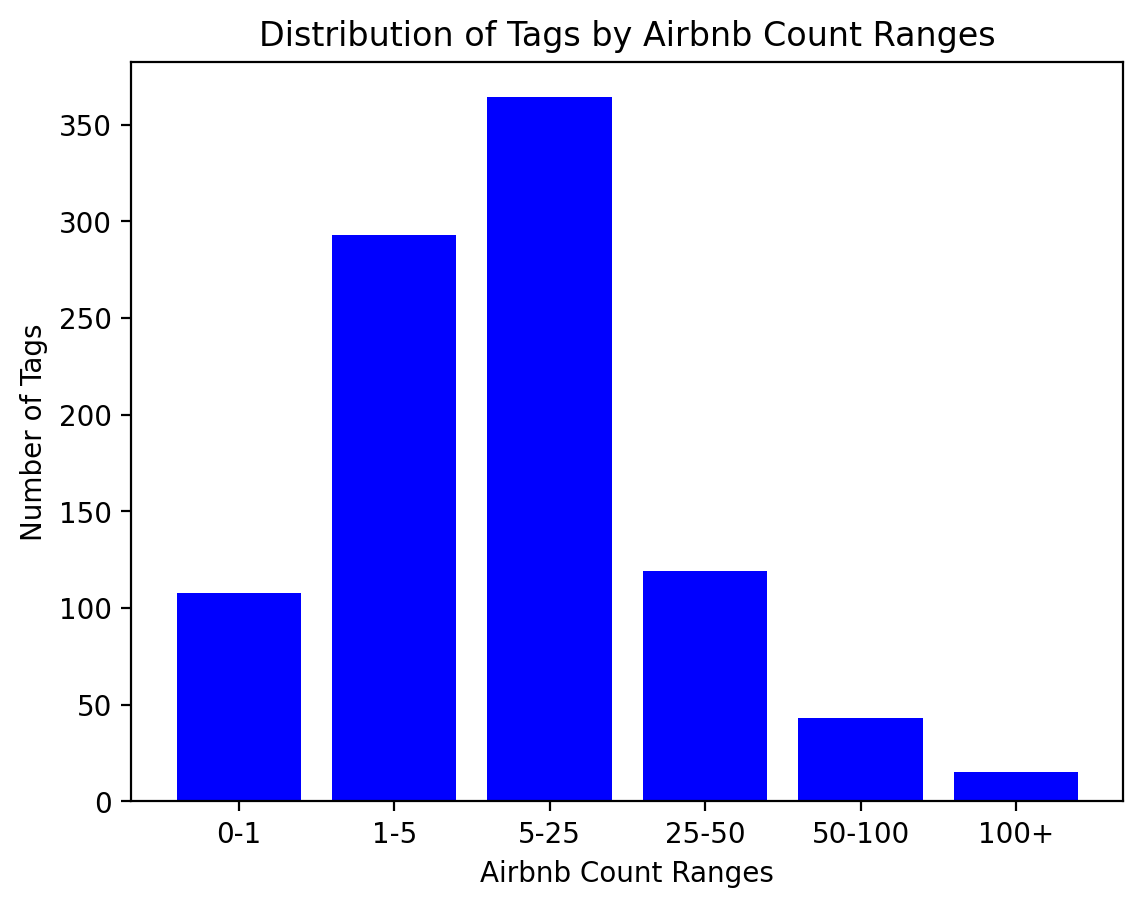

In [ ]:
bins = [0, 1, 5, 25, 50, 100, 150]
labels = ["0-1", "1-5", "5-25", "25-50", "50-100", "100+"]

geo_info_rep = geo_info
geo_info_rep["Tag"] = geo_info_rep.index

geo_info_rep["Airbnb_Range"] = pd.cut(
    geo_info["Airbnb_Number"], bins=bins, labels=labels
)

tag_counts = geo_info.groupby("Airbnb_Range")["Tag"].count()

plt.bar(tag_counts.index, tag_counts.values, color="b")
plt.xlabel("Airbnb Count Ranges")
plt.ylabel("Number of Tags")
plt.title("Distribution of Tags by Airbnb Count Ranges")
plt.show()  # Display the plo

# NANs

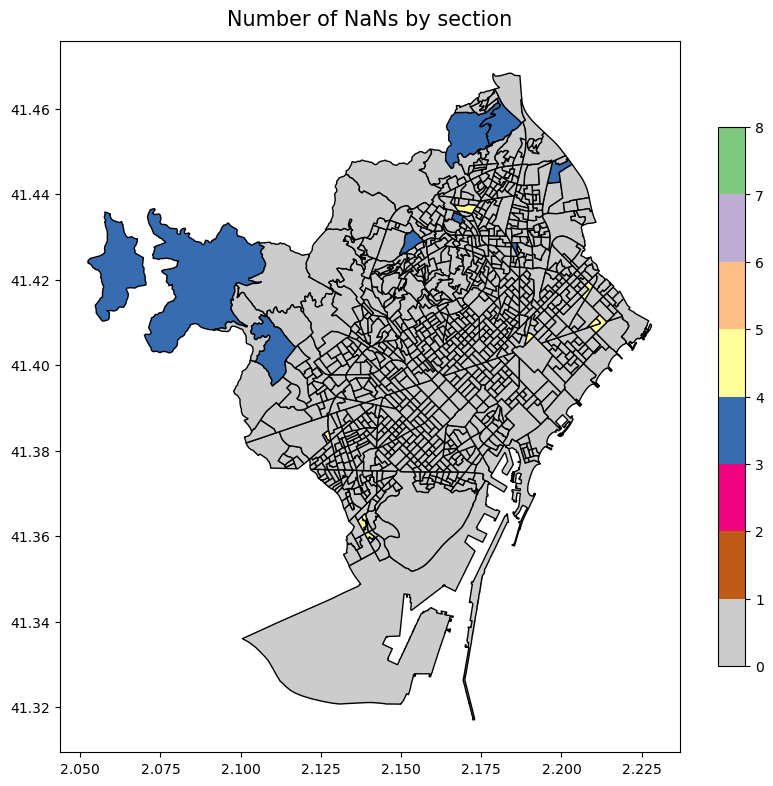

In [53]:
# Colormap
cmap = plt.cm.Accent_r  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]  # extract all colors from the .jet map
cmaplist[0] = "0.8"  # force the first color entry to be grey
bounds = np.linspace(0, 8, 9)  # define the bins and normalize
my_norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
my_cmap = mpl.colors.LinearSegmentedColormap.from_list("Custom cmap", cmaplist, cmap.N)

geo_nans = geo_info.copy()
geo_nans["NaNs"] = pd.isnull(sect).sum(axis=1)

fig, ax = plt.subplots(figsize=(10, 10))

geo_nans.plot(
    ax=ax,
    column="NaNs",
    edgecolor="black",
    legend=True,
    norm=my_norm,
    cmap=my_cmap,
    figsize=(20, 20),
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Number of NaNs by section", fontsize=15, y=1.01)

if SAVE_FIGS:
    plt.savefig(DIR_EDA / "nans.svg", format="svg")

plt.show()